In [50]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [51]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)
        self.x = df.iloc[:, 0].values
        self.y = df.iloc[:, 1].values
        self.length = len(df)

    def __getitem__(self, index):
        x = torch.FloatTensor([self.x[index] ** 2, self.x[index]])
        y = torch.FloatTensor([self.y[index]])
        return x, y

    def __len__(self):
        return self.length

In [52]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(2, 1)

    def forward(self, x):
        x = self.layer(x)
        return x

In [53]:
train_dataset = CustomDataset("../datasets/non_linear.csv")
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

print(f"Dataset size: {len(train_dataset)}")
print(f"Batch size: 16")
print(f"Number of batches: {len(train_dataloader)}")

Dataset size: 67
Batch size: 16
Number of batches: 4


In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CustomModel().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [55]:
for epoch in range(10000):
    cost = 0.0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss

    cost = cost / len(train_dataloader)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch : {epoch+1:4d}, Model : {list(model.parameters())}, Cost : {cost:.3f}")

Epoch : 1000, Model : [Parameter containing:
tensor([[ 2.8662, -1.3388]], requires_grad=True), Parameter containing:
tensor([0.9500], requires_grad=True)], Cost : 12.886
Epoch : 2000, Model : [Parameter containing:
tensor([[ 2.8587, -1.3395]], requires_grad=True), Parameter containing:
tensor([1.0913], requires_grad=True)], Cost : 13.534
Epoch : 3000, Model : [Parameter containing:
tensor([[ 2.8795, -1.3359]], requires_grad=True), Parameter containing:
tensor([1.1914], requires_grad=True)], Cost : 12.857
Epoch : 4000, Model : [Parameter containing:
tensor([[ 2.8673, -1.3349]], requires_grad=True), Parameter containing:
tensor([1.2588], requires_grad=True)], Cost : 12.089
Epoch : 5000, Model : [Parameter containing:
tensor([[ 2.8553, -1.3360]], requires_grad=True), Parameter containing:
tensor([1.3071], requires_grad=True)], Cost : 11.852
Epoch : 6000, Model : [Parameter containing:
tensor([[ 2.8506, -1.3373]], requires_grad=True), Parameter containing:
tensor([1.3406], requires_grad=Tr

In [56]:
with torch.no_grad():
    model.eval()
    inputs = torch.FloatTensor(
        [
            [1 ** 2, 1],
            [5 ** 2, 5],
            [11 ** 2, 11]
        ]
    ).to(device)
    outputs = model(inputs)
    print(outputs)

tensor([[  2.9291],
        [ 66.2634],
        [332.9204]])


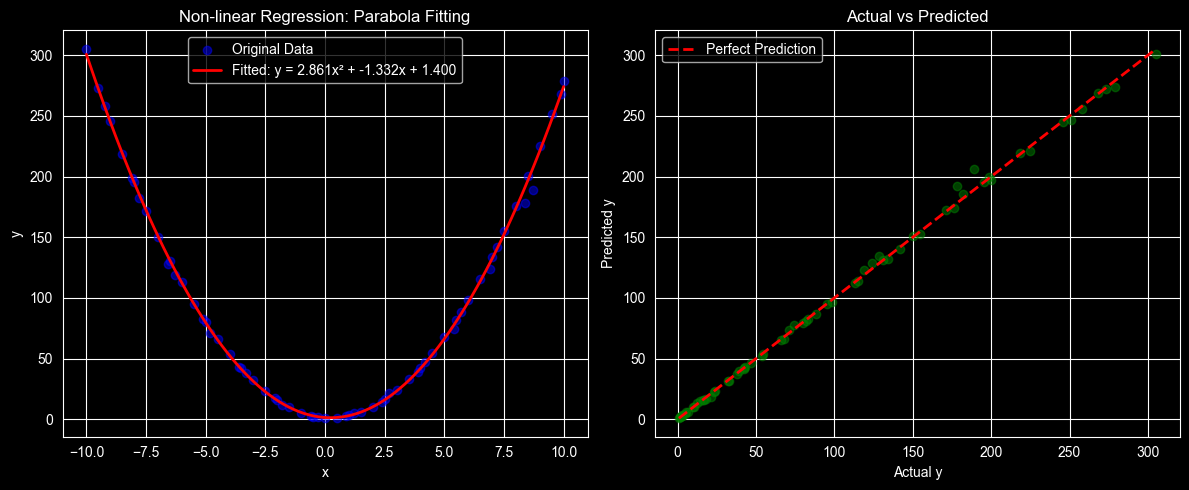


Learned Equation:
  y = 2.8609·x² + -1.3320·x + 1.4001


In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Load original data for visualization
df = pd.read_csv("../datasets/non_linear.csv")
original_x = df.iloc[:, 0].values
original_y = df.iloc[:, 1].values

# Generate smooth curve for prediction
x_range = np.linspace(original_x.min(), original_x.max(), 100)
x_input = torch.FloatTensor([[x**2, x] for x in x_range]).to(device)

with torch.no_grad():
    model.eval()
    y_pred = model(x_input).cpu().numpy()

# Get model parameters
w1 = model.layer.weight[0][0].item()  # coefficient for x²
w2 = model.layer.weight[0][1].item()  # coefficient for x
b = model.layer.bias[0].item()        # bias

# Visualization
plt.figure(figsize=(12, 5))

# Plot 1: Data and fitted curve
plt.subplot(1, 2, 1)
plt.scatter(original_x, original_y, alpha=0.5, label='Original Data', color='blue')
plt.plot(x_range, y_pred, 'r-', linewidth=2, label=f'Fitted: y = {w1:.3f}x² + {w2:.3f}x + {b:.3f}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Non-linear Regression: Parabola Fitting')
plt.legend()
plt.grid(True)

# Plot 2: Actual vs Predicted comparison
plt.subplot(1, 2, 2)
# Get predictions for original x values
x_original_input = torch.FloatTensor([[x**2, x] for x in original_x]).to(device)
with torch.no_grad():
    y_original_pred = model(x_original_input).cpu().numpy().flatten()

plt.scatter(original_y, y_original_pred, alpha=0.5, color='green')
plt.plot([original_y.min(), original_y.max()], 
         [original_y.min(), original_y.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print model equation
print("\n" + "=" * 50)
print("Learned Equation:")
print(f"  y = {w1:.4f}·x² + {w2:.4f}·x + {b:.4f}")
print("=" * 50)

In [58]:
torch.save(
    model,
    "../models/model.pt"
)

In [59]:
torch.save(
    model.state_dict(),
    "../models/model_state_dict.pt"
)